In [5]:
%matplotlib inline
import fipy as fp
from fipy.tools.dump import read
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as p
import json
from fvm_utils import *

In [2]:
state_county = "Georgia_Fulton"
#state_county = "Illinois_Cook"

In [3]:
fipyFolder = f"/project/vitelli/dsseara/schelling/sims/2024-08-08_fipy_inferredParams+growth/data_forJonathan/{state_county}_small/fipy_output"
fipyFolder = f"./data/{state_county}_small/fipy_output"
fipyFiles = sorted(glob(os.path.join(fipyFolder, "*.fipy")))

Each element of `fipyFiles` contains information for a given time point. Here, we will load a single time point

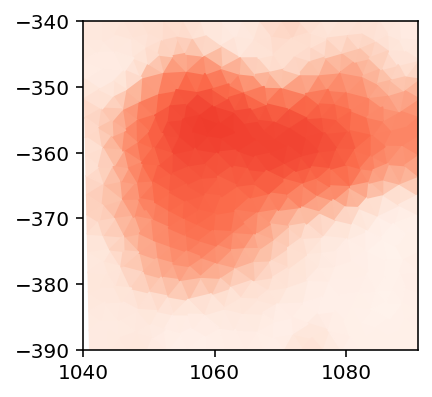

In [6]:
idx = 100
fig, ax = plt.subplots(dpi=144, figsize=(3, 3))
for file in fipyFiles[idx:idx+1]:
    ϕW, ϕB, t = read(file)
    plot_mesh(ϕB, ϕB.mesh, ax,
              cmap=plt.cm.Reds,
              vmin=0, vmax=1)
    

In [7]:
all_gradients, sociohydro_gradients = calc_gradients(ϕW, ϕB)

The variable `all_gradients` contains all scalar valued combinations of up to 4 gradients of two fields, $\phi_W$ and $\phi_B$, in the following order:
$$
\text{all\_gradients} = 
\begin{pmatrix}
    \nabla^2 \phi_W \\
    \nabla^4 \phi_W \\
    \nabla^2 \phi_B \\
    \nabla^4 \phi_B \\
    \nabla \phi_W \cdot \nabla \phi_W \\
    \nabla \phi_B \cdot \nabla \phi_B \\
    \nabla \phi_W \cdot \nabla \phi_B \\
    \nabla \phi_W \cdot \nabla^3 \phi_W \\
    \nabla \phi_W \cdot \nabla^3 \phi_B \\
    \nabla \phi_B \cdot \nabla^3 \phi_W \\
    \nabla \phi_B \cdot \nabla^3 \phi_B
\end{pmatrix}
$$

In [8]:
[ϕW_lap,
ϕW_bilap,
ϕB_lap,
ϕB_bilap,
ϕW_grad_ϕW_grad,
ϕB_grad_ϕB_grad,
ϕW_grad_ϕB_grad,
ϕW_grad_ϕW_gradlap,
ϕW_grad_ϕB_gradlap,
ϕB_grad_ϕW_gradlap,
ϕB_grad_ϕB_gradlap] = all_gradients

In [9]:
# calculate vector gradients just to see them
ϕW_grad = ϕW.grad
ϕW_lap_grad = ϕW_lap.grad

ϕB_grad = ϕB.grad
ϕB_lap_grad = ϕB_lap.grad

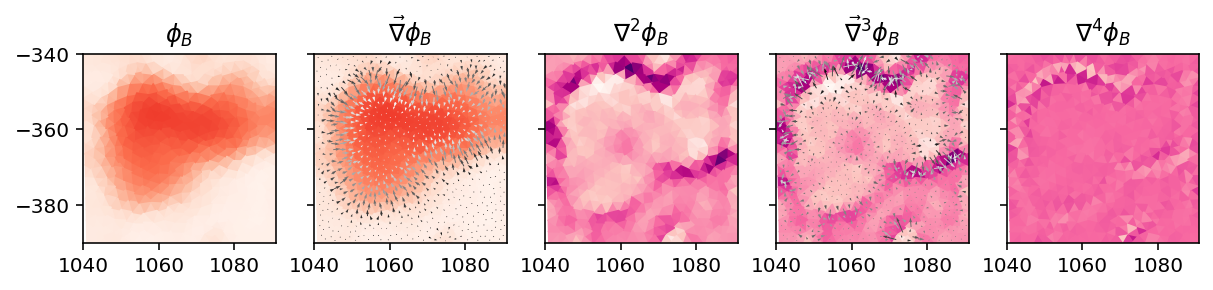

In [10]:
fig, ax = plt.subplots(1, 5, dpi=144, figsize=(10, 2), sharey=True)

# original field
plot_mesh(ϕB, ϕB.mesh, ax[0], cmap=plt.cm.Reds,
          vmin=0, vmax=1)
ax[0].set(title=r"$\phi_B$")

# plot gradient
x, y = ϕB_grad.mesh.cellCenters.value
u, v = ϕB_grad.value
plot_mesh(ϕB, ϕB.mesh, ax[1], cmap=plt.cm.Reds,
          vmin=0, vmax=1)
ax[1].quiver(x, y, u, v, ϕB.value, cmap="Greys_r", width=5e-3)
ax[1].set(title=r"$\vec{\nabla} \phi_B$")

# plot laplacian
plot_mesh(ϕB_lap, ϕB_lap.mesh, ax[2], cmap=plt.cm.RdPu)
ax[2].set(title=r"$\nabla^2 \phi_B$")

# plot gradient of laplacian
x, y = ϕB_lap_grad.mesh.cellCenters.value
u, v = ϕB_lap_grad.value
plot_mesh(ϕB_lap, ϕB_lap.mesh, ax[3], cmap=plt.cm.RdPu)
ax[3].quiver(x, y, u, v, ϕB_lap.value, cmap="Greys_r", width=5e-3)
ax[3].set(title=r"$\vec{\nabla}^3 \phi_B$")

# plot bilaplacian
plot_mesh(ϕB_bilap, ϕB_bilap.mesh, ax[4],
          cmap=plt.cm.RdPu, vmin=-0.1, vmax=0.1)
ax[4].set(title=r"$\nabla^4 \phi_B$")

for a in ax.ravel():
    a.set_aspect(1)

The variable `sociohydro_gradients` is a length 2 list that combines the gradients as they appear in the sociohydrodynamic equations, to aid in parameter inference.

For reference, the sociohydrodynamic equations are:
$$
\partial_t \phi_i = T_i \left( \phi_0 \nabla^2 \phi_i - \phi_i \nabla^2 \phi_0 \right) - \nabla \cdot \left( \phi_0 \phi_i \left(\nabla \pi_i + \Gamma_i \nabla^3 \phi_i \right) \right)
$$
where $\phi_0 = 1 - \phi_1 - \phi_2$ is the vacancy fraction, $T_i$ is a temperature (diffusion constant) and $\Gamma_i$ is a surface tension.

In our simulations, we use a utility function $\pi_i(\vec{\phi})$ given by generic quadratic function:
$$\pi_i(\vec{\phi}) = \sum_j k_{ij} \phi_j + \sum_{jk} \nu_{ijk} \phi_j \phi_k$$

Given the input `calc_gradients(var1, var2)`, `sociohydro_gradients[0]` gives the coefficients for the population represented by `var1`, and `sociohydro_gradients[1]` gives the coefficients for the population represented by `var2`. Each of these lists is given by:
```
sociohydro_gradients[i] = 
[
    Ti_term,
    kii_term,
    kij_term,
    nuiii_term,
    nuiij_term,
    νijj_term,
    Γi_term
]
```
where
$$
\begin{align}
T_i &= \phi_0 \nabla^2 \phi_i - \phi_i \nabla^2 \phi_0 \\
k_{ij} &= \nabla \cdot \left( \phi_0 \phi_i \nabla \phi_j \right) \\
\nu_{ijk} &= \nabla \cdot \left( \phi_0 \phi_i \nabla \left(\phi_j \phi_k \right) \right) \\
\Gamma_i &= \nabla \cdot \left( \phi_0 \phi_i \nabla^3 \phi_j \right)
\end{align}
$$

The true values of the parameters used in the simulation are given here

In [11]:
paramfile = f"/project/vitelli/dsseara/schelling/sims/2024-08-08_fipy_inferredParams+growth/data_forJonathan/{state_county}_small/{state_county}_small_NYCinferredParams_params.json"
paramfile = f"./data/{state_county}_small/{state_county}_small_NYCinferredParams_params.json"
with open(paramfile) as f:
    params = json.load(f)
params

{'inputfile': '/project/vitelli/dsseara/schelling/data/decennial/gridded_small/Georgia_Fulton_small.hdf5',
 'sigma': 2.0,
 'duration': 30.0,
 'nt': 300,
 'timestepper': 'linear',
 'dt': 0.01,
 'dexp': 0.05,
 'tempW': 0.3755539904546736,
 'gammaW': 2.4616512730183318,
 'kWW': 7.311385761355476,
 'kWB': 15.983193416357306,
 'nuWWW': -6.40074002350609,
 'nuWWB': -18.90620845706837,
 'nuWBB': -18.60873560375226,
 'growthW': 0.0070171231065852,
 'tempB': 1.7183631376594726,
 'gammaB': 5.232606865421088,
 'kBB': 17.4193447103632,
 'kBW': -9.496633097666733,
 'nuBBB': -32.69229678119011,
 'nuBWB': 3.8468487648737466,
 'nuBWW': 9.856062799745882,
 'growthB': 0.018329126695069,
 'buffer': 1.0,
 'simplify': 1.0,
 'cellsize': 3.0,
 'savefolder': '/project/vitelli/dsseara/schelling/sims/2024-08-08_fipy_inferredParams+growth/data_forJonathan/Georgia_Fulton_small',
 'filename': 'Georgia_Fulton_small_NYCinferredParams'}

In [12]:
[TW_term,
 kWW_term,
 kWB_term,
 νWWW_term,
 νWWB_term,
 νWBB_term,
 ΓW_term] = sociohydro_gradients[0]

[TB_term,
 kBB_term,
 kBW_term,
 νBBB_term,
 νBWB_term,
 νBWW_term,
 ΓB_term] = sociohydro_gradients[1]

In [13]:
# white parameters
TW = params['tempW']
ΓW = params['gammaW']
kWW = params['kWW']
kWB = params['kWB']
νWWW = params['nuWWW']
νWWB = params['nuWWB']
νWBB = params['nuWBB']
gW = params['growthW']

# Black parameters
TB = params['tempB']
ΓB = params['gammaB']
kBW = params['kBW']
kBB = params['kBB']
νBWW = params['nuBWW']
νBWB = params['nuBWB']
νBBB = params['nuBBB']
gB = params['growthB']


# TW, ΓW, νWWW, νWWB, νWBB, kWW, kWB = params[params["demo"]=="W"].val.values
# TB, ΓB, νBBB, νBWB, νBWW, kBB, kBW = params[params["demo"]=="B"].val.values

The true time derivatives should then be approximated as follows (note the minus signs):

In [14]:
dϕW_dt_feat =(TW * TW_term -
              kWW * kWW_term -
              kWB * kWB_term -
              νWWW * νWWW_term -
              νWWB * νWWB_term -
              νWBB * νWBB_term -
              ΓW * ΓW_term)

dϕB_dt_feat =(TB * TB_term -
              kBW * kBW_term -
              kBB * kBB_term -
              νBWW * νBWW_term -
              νBWB * νBWB_term -
              νBBB * νBBB_term -
              ΓB * ΓB_term)

We can compare this with the time derivatives as measured by the values of the fields at 2 

In [15]:
ϕW_plus1, ϕB_plus1, t_plus1 = read(fipyFiles[idx+1])

dϕW_dt = fp.CellVariable(mesh=ϕW.mesh, value=(ϕW_plus1 - ϕW).value / (t_plus1 - t))
dϕB_dt = fp.CellVariable(mesh=ϕB.mesh, value=(ϕB_plus1 - ϕB).value / (t_plus1 - t))

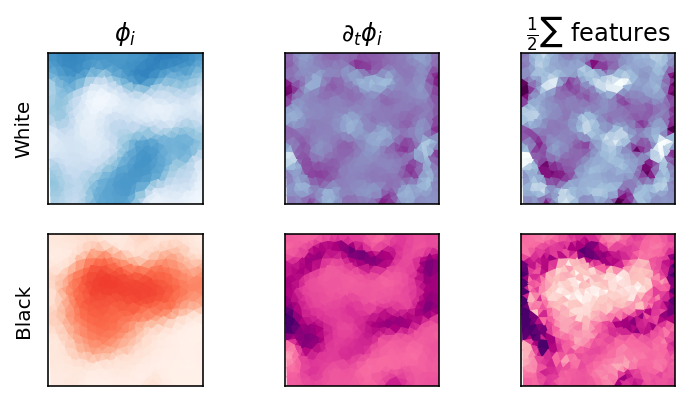

In [16]:
fig, ax = plt.subplots(2, 3, sharey=True, sharex=True, dpi=144, figsize=(6, 3))
plot_mesh(ϕW, ϕW.mesh, ax[0, 0],
          cmap=plt.cm.Blues, vmin=0, vmax=1)
plot_mesh(ϕB, ϕB.mesh, ax[1, 0],
          cmap=plt.cm.Reds, vmin=0, vmax=1)

plot_mesh(dϕW_dt, ϕW.mesh, ax[0, 1],
          cmap=plt.cm.BuPu, vmin=-0.02, vmax=0.02)
plot_mesh(dϕB_dt, ϕB.mesh, ax[1, 1],
          cmap=plt.cm.RdPu, vmin=-0.02, vmax=0.02)

plot_mesh(dϕW_dt_feat/2, ϕW.mesh, ax[0, 2],
          cmap=plt.cm.BuPu, vmin=-0.02, vmax=0.02)
plot_mesh(dϕB_dt_feat/2, ϕB.mesh, ax[1, 2],
          cmap=plt.cm.RdPu, vmin=-0.02, vmax=0.02)


ax[0, 0].set(ylabel="White", title=r"$\phi_i$")
ax[1, 0].set(ylabel="Black")
ax[0, 1].set(title=r"$\partial_t \phi_i$")
ax[0, 2].set(title=r"$\frac{1}{2}\sum$ features")


for a in ax.ravel():
    a.set_aspect(1)
    a.set(xticks=[], yticks=[])


In addition, the simulations used the growth terms $r \phi_i$, with the growth rates $r$ given in the following

In [17]:
growthfile = "/project/vitelli/dsseara/schelling/data/2024-08-05_inferenceWithGrowth/2024-08-07_fillFractionGrowthRates.csv"
growthfile = "./data/2024-08-07_fillFractionGrowthRates.csv"
growth = pd.read_csv(growthfile)
growth

,state,county,growthW,growthB
0,California,Los Angeles,-0.003005,0.008707
1,Georgia,Fulton,0.007017,0.018329
2,Illinois,Cook,-0.009791,0.009451
3,Michigan,Wayne,-0.006920,0.003198
4,New York,Kings,-0.005369,0.003687
5,Texas,Harris,0.001789,0.026798


Here, since we are simulating Fulton County Georgia, we used the values in row 1 of the above table

In [18]:
# gW = growth[(growth.state=="Georgia") & (growth.county=="Fulton")]["growthW"].iloc[0]
# gB = growth[(growth.state=="Georgia") & (growth.county=="Fulton")]["growthB"].iloc[0]

dϕW_dt_feat_growth =(TW * TW_term -
                     kWW * kWW_term -
                     kWB * kWB_term -
                     νWWW * νWWW_term -
                     νWWB * νWWB_term -
                     νWBB * νWBB_term -
                     ΓW * ΓW_term +
                     gW * ϕW)

dϕB_dt_feat_growth =(TB * TB_term -
                     kBW * kBW_term -
                     kBB * kBB_term -
                     νBWW * νBWW_term -
                     νBWB * νBWB_term -
                     νBBB * νBBB_term -
                     ΓB * ΓB_term +
                     gB * ϕB)

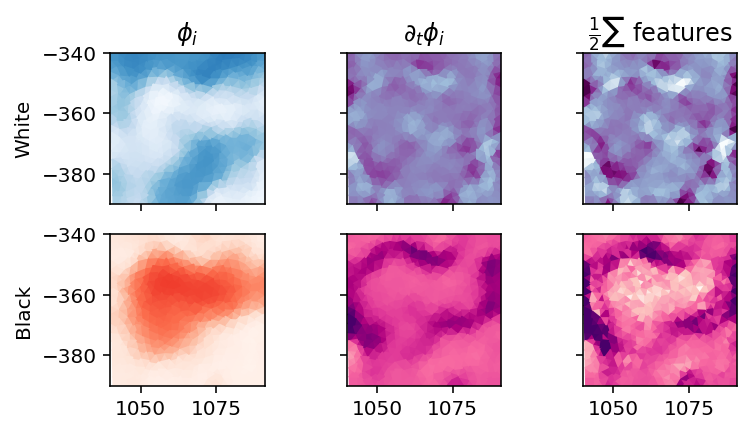

In [19]:
fig, ax = plt.subplots(2, 3, sharey=True, sharex=True, dpi=144, figsize=(6, 3))
plot_mesh(ϕW, ϕW.mesh, ax[0, 0],
          cmap=plt.cm.Blues, vmin=0, vmax=1)
plot_mesh(ϕB, ϕB.mesh, ax[1, 0],
          cmap=plt.cm.Reds, vmin=0, vmax=1)

plot_mesh(dϕW_dt, dϕW_dt.mesh, ax[0, 1],
          cmap=plt.cm.BuPu, vmin=-0.02, vmax=0.02)
plot_mesh(dϕB_dt, dϕB_dt.mesh, ax[1, 1],
          cmap=plt.cm.RdPu, vmin=-0.02, vmax=0.02)

plot_mesh(dϕW_dt_feat_growth/2, dϕW_dt_feat.mesh, ax[0, 2],
          cmap=plt.cm.BuPu, vmin=-0.02, vmax=0.02)
plot_mesh(dϕB_dt_feat_growth/2, dϕB_dt_feat.mesh, ax[1, 2],
          cmap=plt.cm.RdPu, vmin=-0.02, vmax=0.02)


ax[0, 0].set(ylabel="White", title=r"$\phi_i$")
ax[1, 0].set(ylabel="Black")
ax[0, 1].set(title=r"$\partial_t \phi_i$")
ax[0, 2].set(title=r"$\frac{1}{2} \sum$ features")


for a in ax.ravel():
    a.set_aspect(1)
